## 1) Import modules

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## 2) Load Data

In [2]:
# Reading the data
dataset = pd.read_csv('Raw input/train.csv',  index_col='id', parse_dates = ['purchase_date', 'release_date'])

print('Dataset shape: ', dataset.shape)
print(dataset.info())
dataset.head(2)

Dataset shape:  (357, 10)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 357 entries, 0 to 356
Data columns (total 10 columns):
playtime_forever          357 non-null float64
is_free                   357 non-null bool
price                     357 non-null float64
genres                    357 non-null object
categories                357 non-null object
tags                      357 non-null object
purchase_date             355 non-null datetime64[ns]
release_date              357 non-null datetime64[ns]
total_positive_reviews    355 non-null float64
total_negative_reviews    355 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(4), object(3)
memory usage: 28.2+ KB
None


,playtime_forever,is_free,price,genres,categories,tags,purchase_date,release_date,total_positive_reviews,total_negative_reviews
id,,,,,,,,,,
0,0.000000,False,3700.0,"Adventure,Casual,Indie","Single-player,Steam Trading Cards,Steam Cloud","Indie,Adventure,Story Rich,Casual,Atmospheric,Exploration,First-Person,Stealth,Choices Matter,Singleplayer,Walking Simulator,Short,Drama",2018-07-02,2013-12-10,372.0,96.0
1,0.016667,True,0.0,RPG,"Single-player,Partial Controller Support","Mod,Utilities,RPG,Game Development,Singleplayer,Free to Play",2016-11-26,2015-08-12,23.0,0.0


In [3]:
# Reading the test data
test_df = pd.read_csv('Raw input/test.csv',  index_col='id', parse_dates = ['purchase_date', 'release_date'])
print('Test data shape: ', test_df.shape)
print(test_df.info())
test_df.head(2)

Test data shape:  (90, 9)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 0 to 89
Data columns (total 9 columns):
is_free                   90 non-null bool
price                     90 non-null int64
genres                    90 non-null object
categories                90 non-null object
tags                      90 non-null object
purchase_date             88 non-null datetime64[ns]
release_date              90 non-null datetime64[ns]
total_positive_reviews    88 non-null float64
total_negative_reviews    88 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 6.4+ KB
None


,is_free,price,genres,categories,tags,purchase_date,release_date,total_positive_reviews,total_negative_reviews
id,,,,,,,,,
0,False,3500,"Action,Adventure","Single-player,Full controller support","Action,Adventure,Horror,Third Person,Singleplayer,Thriller,Third-Person Shooter,Psychological Horror,Mystery,Arcade,Atmospheric,Shooter,Cinematic,Survival Horror,Detective,Story Rich,Survival,Supernatural,Controller,Short",2018-10-28,2012-05-22,2607.0,1122.0
1,False,11600,"Action,Adventure,Strategy","Single-player,Multi-player,Online Multi-Player,Cross-Platform Multiplayer,Steam Achievements,Steam Trading Cards,Steam Cloud","Mechs,Strategy,Turn-Based,Turn-Based Tactics,Sci-fi,Turn-Based Strategy,Tactical,Robots,Singleplayer,Multiplayer,RPG,Action,Futuristic,Space,Character Customization,Management,Adventure,Story Rich,Great Soundtrack,Difficult",2019-07-20,2018-04-24,5762.0,2235.0


## 3) Data Pre-processing

### 3.1) Filling Missing Data

In [4]:
# Filling float type using forwardfill
for column in ['total_positive_reviews','total_negative_reviews']:
        dataset[column] = dataset[column].interpolate()
        test_df[column] = test_df[column].interpolate()

# Filling datetime obj using forwardfill
dataset['purchase_date'] = dataset['purchase_date'].ffill()
test_df['purchase_date'] = test_df['purchase_date'].ffill()

### 3.2) Handling datetime Data

In [5]:
def extract_date_columns(df,columns):
    for column in columns:
        df[column+'_year'] = df[column].apply(lambda x: x.year)
        df[column+'_month'] = df[column].apply(lambda x: x.month)
        df[column+'_day'] = df[column].apply(lambda x: x.day) # For timestamp the member is 'day'
        
def get_days_between(df,before_col,after_col):
    df['date_diff'] = (df[after_col] - df[before_col]).apply(lambda x: x.days)
    
def get_timestamp(df,columns):
    for column in columns:
        df[column+'_timestamp'] = df[column].apply(lambda x: x.timestamp())


date_columns = ['release_date','purchase_date']
get_timestamp(dataset,date_columns)
get_timestamp(test_df,date_columns)

# logical filter: release date cant be more than purchase date
dataset = dataset[dataset['purchase_date_timestamp'] >= dataset['release_date_timestamp']]

get_days_between(dataset,'release_date','purchase_date')
get_days_between(test_df,'release_date','purchase_date')

extract_date_columns(dataset,date_columns)
extract_date_columns(test_df,date_columns)

dataset.drop(date_columns, axis=1, inplace=True)
test_df.drop(date_columns, axis=1, inplace=True)

### 3.3) Filter out Outliers

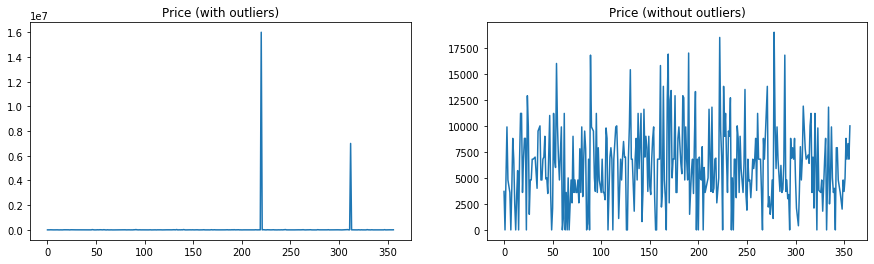

In [6]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    tolerance = 2
    fence_low  = q1 - tolerance*iqr
    fence_high = q3 + tolerance*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

# Column: 'price'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
ax1.plot(dataset['price'])
ax1.set_title('Price (with outliers)')

dataset = remove_outlier(dataset,'price')

ax2.plot(dataset['price'])
ax2.set_title('Price (without outliers)')

plt.show()

# print('--------------------------------------------------------------------------------------------------')

# # Column: 'playtime_forever'
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
# ax1.plot(dataset['playtime_forever'])
# ax1.set_title('playtime_forever (with outliers)')

# dataset = dataset[dataset['playtime_forever'] < 50]
# # dataset = remove_outlier(dataset,'playtime_forever')

# ax2.plot(dataset['playtime_forever'])
# ax2.set_title('playtime_forever (without outliers)')

# plt.show()
    
# ------------- Reset index -------------
dataset.reset_index(inplace=True, drop=True) 

### 3.4) Handling Boolean Data

In [7]:
dataset['is_free'] = dataset['is_free'].astype(int)
test_df['is_free'] = test_df['is_free'].astype(int)

### 3.5) Handling Skewed Data

                             Skew
total_negative_reviews  11.413241
total_positive_reviews  5.946390 


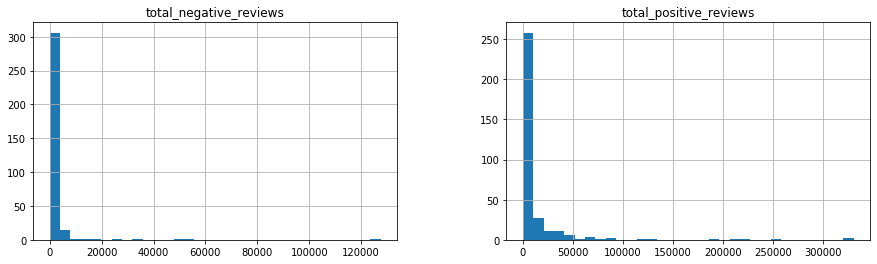

----------------------------------------------------------------------------------------------------
                            Skew
total_negative_reviews -0.603592
total_positive_reviews -0.764769


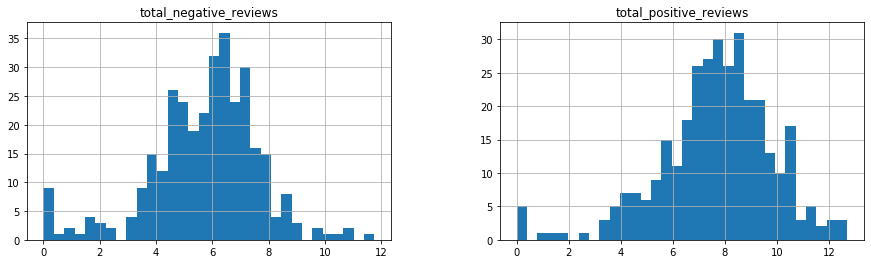

----------------------------------------------------------------------------------------------------


In [8]:
def show_skewness(df):
    skew_feats = df.skew(axis = 0)
    skewness = pd.DataFrame({'Skew': skew_feats})
    print(skewness)
    df.hist(bins=int(df.shape[0]/10),figsize=(15,4))
    plt.show()
    print('----------------------------------------------------------------------------------------------------')


num_cols = ['total_negative_reviews','total_positive_reviews']

show_skewness(dataset[num_cols])

# Reduce positive skewness
dataset[num_cols] = dataset[num_cols].applymap(np.log1p)
show_skewness(dataset[num_cols])

                            Skew
total_negative_reviews  7.900891
total_positive_reviews  3.919701


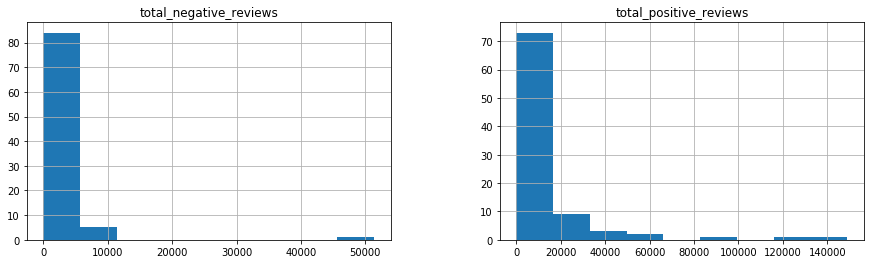

----------------------------------------------------------------------------------------------------
                            Skew
total_negative_reviews -0.513381
total_positive_reviews -0.952302


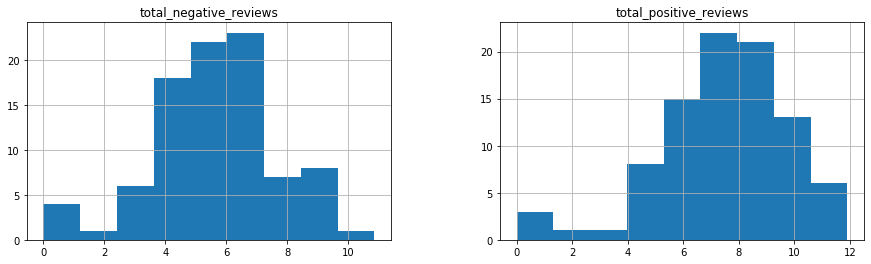

----------------------------------------------------------------------------------------------------


In [9]:
num_cols = ['total_negative_reviews','total_positive_reviews']

show_skewness(test_df[num_cols])

# Reduce positive skewness
test_df[num_cols] = test_df[num_cols].applymap(np.log1p)
show_skewness(test_df[num_cols])

### 3.5) Encoding Categorical Data

In [10]:
def hot_encode(df,columns):
    for column in columns:
        dummy_df = df[column].str.get_dummies(",").add_prefix(column + '_')
        dummy_df.columns = dummy_df.columns.str.replace(' ', '_').str.lower()
        df = df.join(dummy_df)
    return df


categorical_columns = ["genres", "categories", "tags"]

test_df = hot_encode(test_df,categorical_columns) # Splitting grouped string type category into separate columns
test_df.drop(categorical_columns, axis=1, inplace=True)

dataset = hot_encode(dataset,categorical_columns) # Splitting grouped string type category into separate columns
dataset.drop(categorical_columns, axis=1, inplace=True)

### 3.6) Splitting the dataset into X & Y

In [11]:
# ----------- Extracting only available columns in test data -------------
X = dataset.drop('playtime_forever',axis=1)
Y = dataset['playtime_forever'].copy()

# See the distribution target column
# print(Y.value_counts(normalize=True))

avail_cols = list(set(dataset.columns) & set(test_df.columns))
X = X[avail_cols]
test_df = test_df[avail_cols]
X.head(2)

,tags_hack_and_slash,tags_anime,tags_split_screen,tags_replay_value,tags_horror,tags_tactical,tags_thriller,release_date_month,tags_top-down_shooter,tags_multiplayer,genres_action,tags_3d_vision,tags_retro,tags_rpgmaker,categories_steamvr_collectibles,tags_games_workshop,categories_remote_play_on_tablet,tags_shooter,categories_steam_achievements,tags_visual_novel,tags_mechs,tags_villain_protagonist,tags_zombies,tags_physics,tags_linear,tags_cute,tags_top-down,tags_character_customization,purchase_date_month,tags_demons,categories_shared/split_screen,genres_strategy,tags_philisophical,tags_rpg,tags_management,tags_moba,purchase_date_timestamp,genres_violent,tags_hand-drawn,genres_indie,genres_massively_multiplayer,tags_controller,tags_historical,tags_magic,tags_shoot_'em_up,tags_choices_matter,tags_short,categories_stats,categories_includes_level_editor,tags_psychedelic,tags_level_editor,tags_crpg,tags_dark,tags_walking_simulator,tags_survival_horror,tags_arena_shooter,tags_platformer,tags_fantasy,categories_full_controller_support,tags_dark_humor,tags_futuristic,tags_gore,tags_warhammer_40k,tags_difficult,tags_family_friendly,categories_multi-player,tags_destruction,tags_turn-based_tactics,tags_benchmark,tags_3d_platformer,tags_drama,tags_building,tags_dark_fantasy,tags_turn-based,tags_1990's,purchase_date_year,tags_action,tags_world_war_ii,genres_nudity,tags_online_co-op,categories_online_multi-player,tags_mouse_only,tags_side_scroller,tags_lovecraftian,categories_steam_leaderboards,tags_political,categories_remote_play_on_phone,tags_beat_'em_up,tags_competitive,tags_memes,tags_mod,tags_first-person,tags_local_multiplayer,tags_open_world,categories_cross-platform_multiplayer,tags_blood,tags_puzzle-platformer,tags_rogue-like,tags_female_protagonist,tags_robots,tags_time_travel,tags_politics,price,tags_realistic,tags_third_person,tags_turn-based_combat,categories_single-player,tags_masterpiece,tags_grand_strategy,tags_post-apocalyptic,tags_sci-fi,tags_colorful,tags_violent,genres_simulation,tags_hunting,tags_aliens,categories_co-op,tags_experimental,tags_space,tags_western,tags_stealth,tags_massively_multiplayer,tags_fmv,tags_cinematic,tags_4x,tags_exploration,tags_local_co-op,tags_minimalist,tags_real-time_with_pause,tags_psychological,categories_mmo,tags_parody,genres_casual,tags_alternate_history,tags_detective,tags_medieval,tags_romance,tags_story_rich,tags_esports,categories_includes_source_sdk,tags_survival,tags_mature,tags_dragons,tags_emotional,tags_resource_management,tags_turn-based_strategy,tags_sandbox,tags_4_player_local,tags_crowdfunded,tags_great_soundtrack,release_date_timestamp,tags_bullet_time,categories_remote_play_on_tv,categories_online_co-op,tags_dynamic_narration,tags_based_on_a_novel,tags_adventure,genres_sports,tags_submarine,tags_trading,tags_loot,tags_supernatural,tags_cult_classic,tags_casual,tags_cyberpunk,tags_mythology,tags_procedural_generation,total_positive_reviews,categories_steam_workshop,tags_heist,tags_team-based,tags_hex_grid,tags_cartoony,categories_local_multi-player,tags_driving,tags_atmospheric,tags_steampunk,tags_parkour,tags_assassin,release_date_day,tags_rts,tags_illuminati,tags_underwater,tags_remake,tags_pixel_graphics,tags_beautiful,tags_fighting,tags_hacking,tags_noir,tags_war,tags_nonlinear,tags_crime,genres_free_to_play,tags_action_rpg,tags_space_sim,tags_narration,tags_stylized,tags_silent_protagonist,purchase_date_day,categories_captions_available,categories_commentary_available,tags_nudity,tags_pvp,tags_moddable,tags_action-adventure,tags_dating_sim,tags_sports,tags_minigames,tags_real-time,date_diff,genres_adventure,tags_relaxing,tags_epic,tags_fast-paced,tags_rogue-lite,tags_psychological_horror,categories_vr_support,tags_fps,categories_local_co-op,tags_science,genres_rpg,tags_comedy,tags_isometric,tags_ninja,tags_education,tags_inventory_management,categories_steam_cloud,tags_simulation,categories_steam_trading_cards,tags_third-person_shooter,tags_2d,tags_diplomacy,tags_

### 3.7) Cleaned Data summary

In [12]:
print('Dataset shape: ', dataset.shape)
print(dataset.info())
dataset.head(2)

Dataset shape:  (328, 371)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Columns: 371 entries, playtime_forever to tags_esports
dtypes: float64(6), int64(365)
memory usage: 950.8 KB
None


,playtime_forever,is_free,price,total_positive_reviews,total_negative_reviews,release_date_timestamp,purchase_date_timestamp,date_diff,release_date_year,release_date_month,release_date_day,purchase_date_year,purchase_date_month,purchase_date_day,genres_action,genres_adventure,genres_animation_&_modeling,genres_audio_production,genres_casual,genres_design_&_illustration,genres_early_access,genres_free_to_play,genres_gore,genres_indie,genres_massively_multiplayer,genres_nudity,genres_rpg,genres_racing,genres_sexual_content,genres_simulation,genres_sports,genres_strategy,genres_utilities,genres_violent,categories_captions_available,categories_co-op,categories_commentary_available,categories_cross-platform_multiplayer,categories_full_controller_support,categories_in-app_purchases,categories_includes_source_sdk,categories_includes_level_editor,categories_local_co-op,categories_local_multi-player,categories_mmo,categories_multi-player,categories_online_co-op,categories_online_multi-player,categories_partial_controller_support,categories_remote_play_on_phone,categories_remote_play_on_tv,categories_remote_play_on_tablet,categories_shared/split_screen,categories_single-player,categories_stats,categories_steam_achievements,categories_steam_cloud,categories_steam_leaderboards,categories_steam_trading_cards,categories_steam_workshop,categories_steamvr_collectibles,categories_vr_support,categories_valve_anti-cheat_enabled,tags_1980s,tags_1990's,tags_2.5d,tags_2d,tags_3d,tags_3d_platformer,tags_3d_vision,tags_4_player_local,tags_4x,tags_atv,tags_action,tags_action_rpg,tags_action-adventure,tags_addictive,tags_adventure,tags_aliens,tags_alternate_history,tags_america,tags_animation_&_modeling,tags_anime,tags_arcade,tags_arena_shooter,tags_artificial_intelligence,tags_assassin,tags_atmospheric,tags_audio_production,tags_automation,tags_base_building,tags_based_on_a_novel,tags_batman,tags_battle_royale,tags_beat_'em_up,tags_beautiful,tags_benchmark,tags_bikes,tags_blood,tags_board_game,tags_building,tags_bullet_hell,tags_bullet_time,tags_crpg,tags_capitalism,tags_card_game,tags_cartoon,tags_cartoony,tags_casual,tags_cats,tags_character_action_game,tags_character_customization,tags_chess,tags_choices_matter,tags_choose_your_own_adventure,tags_cinematic,tags_city_builder,tags_classic,tags_clicker,tags_co-op,tags_co-op_campaign,tags_colorful,tags_comedy,tags_comic_book,tags_competitive,tags_conspiracy,tags_controller,tags_crafting,tags_crime,tags_crowdfunded,tags_cult_classic,tags_cute,tags_cyberpunk,tags_dark,tags_dark_comedy,tags_dark_fantasy,tags_dark_humor,tags_dating_sim,tags_demons,tags_design_&_illustration,tags_destruction,tags_detective,tags_difficult,tags_dinosaurs,tags_diplomacy,tags_documentary,tags_dragons,tags_drama,tags_driving,tags_dungeon_crawler,tags_dungeons_&_dragons,tags_dynamic_narration,tags_dystopian,tags_early_access,tags_economy,tags_education,tags_emotional,tags_epic,tags_episodic,tags_experience,tags_experimental,tags_exploration,tags_fmv,tags_fps,tags_family_friendly,tags_fantasy,tags_fast-paced,tags_female_protagonist,tags_fighting,tags_first-person,tags_flight,tags_free_to_play,tags_funny,tags_futuristic,tags_game_development,tags_games_workshop,tags_god_game,tags_gore,tags_gothic,tags_grand_strategy,tags_great_soundtrack,tags_gun_customization,tags_hack_and_slash,tags_hacking,tags_hand-drawn,tags_heist,tags_hex_grid,tags_hidden_object,tags_historical,tags_horror,tags_horses,tags_hunting,tags_illuminati,tags_immersive_sim,tags_indie,tags_interactive_fiction,tags_inventory_management,tags_investigation,tags_isometric,tags_jrpg,tags_kickstarter,tags_lgbtq+,tags_lara_croft,tags_level_editor,tags_linear,tags_local_co-op,tags_local_multiplayer,tags_logic,tags_loot,tags_lovecraftian,tags_mmorpg,tags_moba,tags_magic,tags_management,tags_mars,tags_martial_arts,tags_massively_multiplayer,tags_masterpiece,tags_mature,tags_mechs,tags_medieval,tags_memes,tags_metroidvania,tags_military,tags_minigames,tags_minimalist,tags_mod,ta

In [13]:
print('Test data shape: ', test_df.shape)
print(test_df.info())
test_df.head(2)

Test data shape:  (90, 278)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 0 to 89
Columns: 278 entries, tags_hack_and_slash to tags_economy
dtypes: float64(4), int64(274)
memory usage: 198.7 KB
None


,tags_hack_and_slash,tags_anime,tags_split_screen,tags_replay_value,tags_horror,tags_tactical,tags_thriller,release_date_month,tags_top-down_shooter,tags_multiplayer,genres_action,tags_3d_vision,tags_retro,tags_rpgmaker,categories_steamvr_collectibles,tags_games_workshop,categories_remote_play_on_tablet,tags_shooter,categories_steam_achievements,tags_visual_novel,tags_mechs,tags_villain_protagonist,tags_zombies,tags_physics,tags_linear,tags_cute,tags_top-down,tags_character_customization,purchase_date_month,tags_demons,categories_shared/split_screen,genres_strategy,tags_philisophical,tags_rpg,tags_management,tags_moba,purchase_date_timestamp,genres_violent,tags_hand-drawn,genres_indie,genres_massively_multiplayer,tags_controller,tags_historical,tags_magic,tags_shoot_'em_up,tags_choices_matter,tags_short,categories_stats,categories_includes_level_editor,tags_psychedelic,tags_level_editor,tags_crpg,tags_dark,tags_walking_simulator,tags_survival_horror,tags_arena_shooter,tags_platformer,tags_fantasy,categories_full_controller_support,tags_dark_humor,tags_futuristic,tags_gore,tags_warhammer_40k,tags_difficult,tags_family_friendly,categories_multi-player,tags_destruction,tags_turn-based_tactics,tags_benchmark,tags_3d_platformer,tags_drama,tags_building,tags_dark_fantasy,tags_turn-based,tags_1990's,purchase_date_year,tags_action,tags_world_war_ii,genres_nudity,tags_online_co-op,categories_online_multi-player,tags_mouse_only,tags_side_scroller,tags_lovecraftian,categories_steam_leaderboards,tags_political,categories_remote_play_on_phone,tags_beat_'em_up,tags_competitive,tags_memes,tags_mod,tags_first-person,tags_local_multiplayer,tags_open_world,categories_cross-platform_multiplayer,tags_blood,tags_puzzle-platformer,tags_rogue-like,tags_female_protagonist,tags_robots,tags_time_travel,tags_politics,price,tags_realistic,tags_third_person,tags_turn-based_combat,categories_single-player,tags_masterpiece,tags_grand_strategy,tags_post-apocalyptic,tags_sci-fi,tags_colorful,tags_violent,genres_simulation,tags_hunting,tags_aliens,categories_co-op,tags_experimental,tags_space,tags_western,tags_stealth,tags_massively_multiplayer,tags_fmv,tags_cinematic,tags_4x,tags_exploration,tags_local_co-op,tags_minimalist,tags_real-time_with_pause,tags_psychological,categories_mmo,tags_parody,genres_casual,tags_alternate_history,tags_detective,tags_medieval,tags_romance,tags_story_rich,tags_esports,categories_includes_source_sdk,tags_survival,tags_mature,tags_dragons,tags_emotional,tags_resource_management,tags_turn-based_strategy,tags_sandbox,tags_4_player_local,tags_crowdfunded,tags_great_soundtrack,release_date_timestamp,tags_bullet_time,categories_remote_play_on_tv,categories_online_co-op,tags_dynamic_narration,tags_based_on_a_novel,tags_adventure,genres_sports,tags_submarine,tags_trading,tags_loot,tags_supernatural,tags_cult_classic,tags_casual,tags_cyberpunk,tags_mythology,tags_procedural_generation,total_positive_reviews,categories_steam_workshop,tags_heist,tags_team-based,tags_hex_grid,tags_cartoony,categories_local_multi-player,tags_driving,tags_atmospheric,tags_steampunk,tags_parkour,tags_assassin,release_date_day,tags_rts,tags_illuminati,tags_underwater,tags_remake,tags_pixel_graphics,tags_beautiful,tags_fighting,tags_hacking,tags_noir,tags_war,tags_nonlinear,tags_crime,genres_free_to_play,tags_action_rpg,tags_space_sim,tags_narration,tags_stylized,tags_silent_protagonist,purchase_date_day,categories_captions_available,categories_commentary_available,tags_nudity,tags_pvp,tags_moddable,tags_action-adventure,tags_dating_sim,tags_sports,tags_minigames,tags_real-time,date_diff,genres_adventure,tags_relaxing,tags_epic,tags_fast-paced,tags_rogue-lite,tags_psychological_horror,categories_vr_support,tags_fps,categories_local_co-op,tags_science,genres_rpg,tags_comedy,tags_isometric,tags_ninja,tags_education,tags_inventory_management,categories_steam_cloud,tags_simulation,categories_steam_trading_cards,tags_third-person_shooter,tags_2d,tags_diplomacy,tags_

## 4) Save Cleaned Data

In [14]:
X.to_csv('Cleaned data/X.csv',index_label='id')
Y.to_csv('Cleaned data/Y.csv', header=['playtime_forever'],index_label='id')
test_df.to_csv('Cleaned data/X_test.csv',index_label='id')